In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import numpy as np
import cv2 as cv
import math as m
import os
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

In [3]:

from torchvision import datasets

In [2]:
train_directory = 'data/training/'
test_directory  = 'data/files_for_testing/'

In [11]:
X_train = []
y_train = []
X_test = []
y_test = []

labels = os.listdir(train_directory)

for i, label in enumerate(labels):
    folderpath_train = train_directory + label + '/'
    folderpath_test = test_directory + label + '/'

    for file in os.listdir(folderpath_train):
        img_path = folderpath_train + file
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (128, 128))
        X_train.append(np.array(img))
        y_train.append(i)

    for file in os.listdir(folderpath_test):
        img_path = folderpath_test + file
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (128, 128))
        X_test.append(np.array(img))
        y_test.append(i)

X_train = np.array(X_train) / 255
y_train = np.array(y_train)
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(4352, 128, 128, 3)
(4352,)
(295, 128, 128, 3)
(295,)


<function matplotlib.pyplot.show(close=None, block=None)>

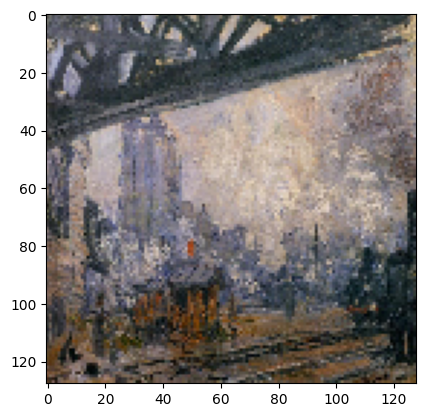

In [23]:
num_img = 1000

plt.imshow(X_train[num_img])
plt.show

In [18]:
print(labels[y_train[num_img]])

Monet


In [12]:
def objective(params):
    model = RandomForestClassifier(n_estimators=params['n_estimators'],
                                  max_depth=params['max_depth'],
                                  min_samples_split=params['min_samples_split'],
                                  random_state=42)
    
    model.fit(X_train.reshape(len(X_train), -1), y_train)
    y_pred = model.predict(X_test.reshape(len(X_test), -1))
    
    accuracy = accuracy_score(y_test, y_pred)
    return -accuracy  # Minimizacja, dlatego minus 



In [39]:
space = {
    'n_estimators': hp.choice('n_estimators', [50, 400, 300]),
    'max_depth': hp.choice('max_depth', [12, 30, None]),
    'min_samples_split': hp.choice('min_samples_split', [2, 15, 3])
}

In [40]:
trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [18:19:53<00:00, 1319.86s/trial, best loss: -0.6203389830508474]    


In [41]:
best_params = {
    'n_estimators': [100, 200, 300][best['n_estimators']],
    'max_depth': [10, 20, 30, None][best['max_depth']],
    'min_samples_split': [2, 5, 10][best['min_samples_split']]
}

print("Najlepsze hiperparametry:", best_params)

Najlepsze hiperparametry: {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 2}


In [42]:
best_model = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                   max_depth=best_params['max_depth'],
                                   min_samples_split=best_params['min_samples_split'],
                                   random_state=42)

best_model.fit(X_train.reshape(len(X_train), -1), y_train)

RandomForestClassifier(max_depth=30, n_estimators=300, random_state=42)

In [21]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weight_dict = {class_idx: weight for class_idx, weight in enumerate(class_weights)}

print(class_weight_dict)

{0: 1.325616813889735, 1: 8.074211502782932, 2: 0.6065505226480836, 3: 4.258317025440313, 4: 4.819490586932448, 5: 0.5870767570484284, 6: 0.42965741929114426}


In [22]:
best_model = RandomForestClassifier(n_estimators=300,
                                   max_depth=30,
                                   min_samples_split=2,
                                   random_state=42,
                                   class_weight=class_weight_dict)

best_model.fit(X_train.reshape(len(X_train), -1), y_train)

RandomForestClassifier(class_weight={0: 1.325616813889735, 1: 8.074211502782932,
                                     2: 0.6065505226480836,
                                     3: 4.258317025440313, 4: 4.819490586932448,
                                     5: 0.5870767570484284,
                                     6: 0.42965741929114426},
                       max_depth=30, n_estimators=300, random_state=42)

In [26]:
y_pred = best_model.predict(X_test.reshape(len(X_test), -1))
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji: {:.2f}%".format(accuracy * 100))

Dokładność klasyfikacji: 59.32%


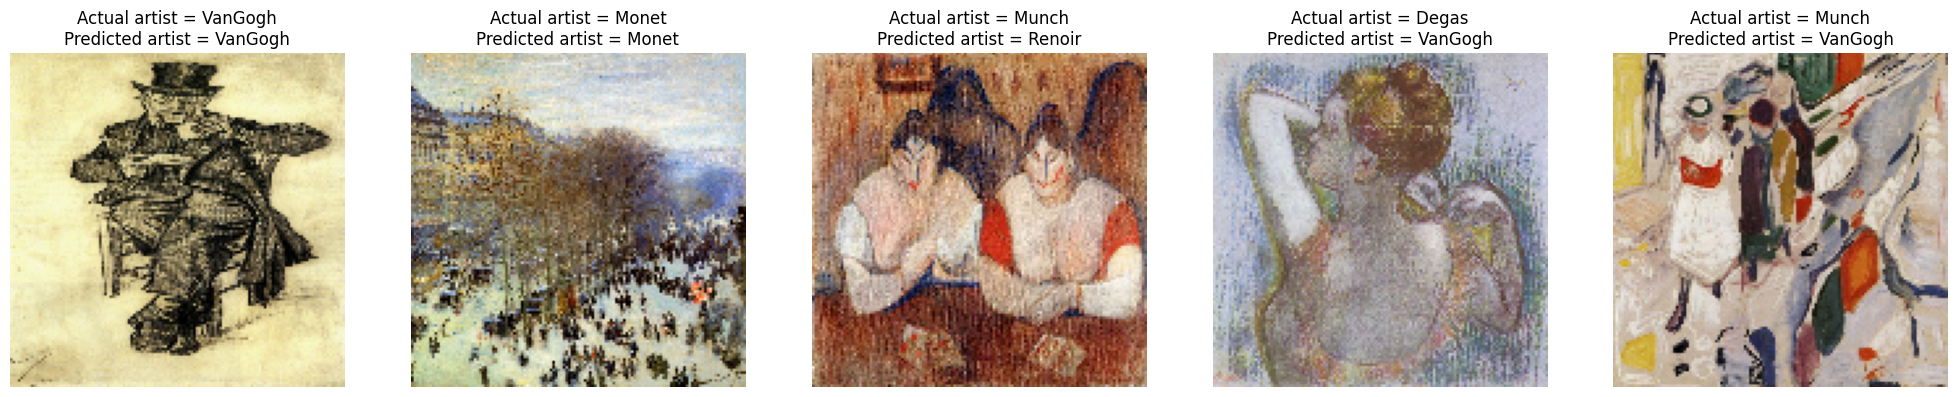

In [49]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

n = 5
fig, axes = plt.subplots(1, n, figsize=(25, 10))

for i in range(n):
    random_artist = random.choice(labels)
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    # Oryginalny obraz
    test_image = plt.imread(random_image_file)

    # Prognozuj artystę
    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    title = "Actual artist = {}\nPredicted artist = {}".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))

    # Wyświetl obraz
    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()

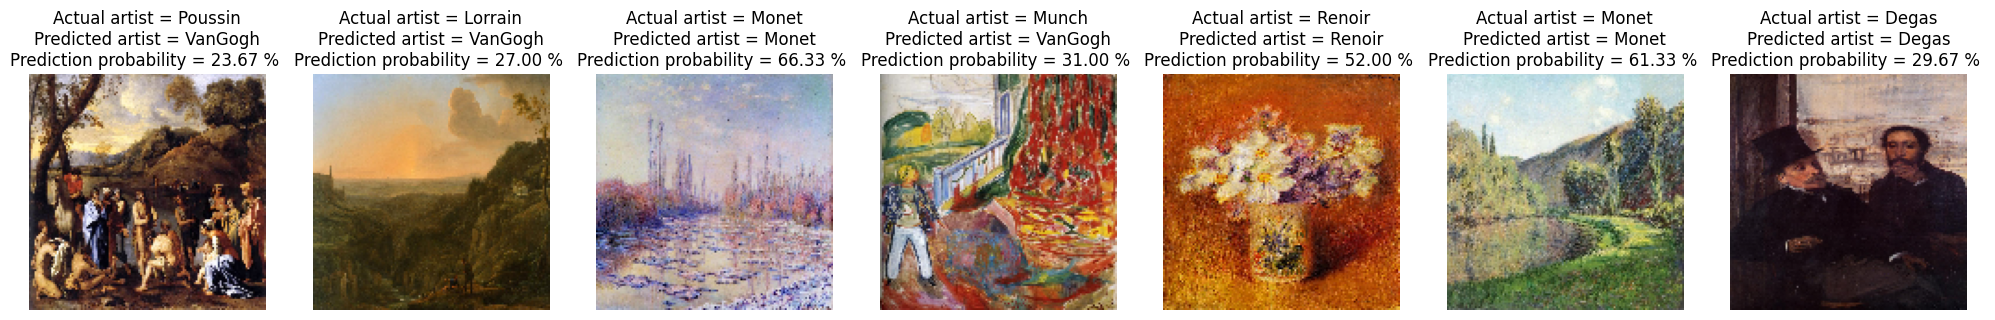

In [28]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))


for i in range(n):
    random_artist = random.choice(labels)
    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = plt.imread(random_image_file)

    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    prediction_probabilities = best_model.predict_proba(test_image.reshape(1, -1))[0]
    max_probability = max(prediction_probabilities)  
    prediction_idx = prediction_probabilities.argmax()  

    title = "Actual artist = {}\nPredicted artist = {}\n".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))
    title += "Prediction probability = {:.2f} % ".format(max_probability * 100)


    # Display the image
    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()


c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Administrator\Desktop\MasterThesis\magisterka\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

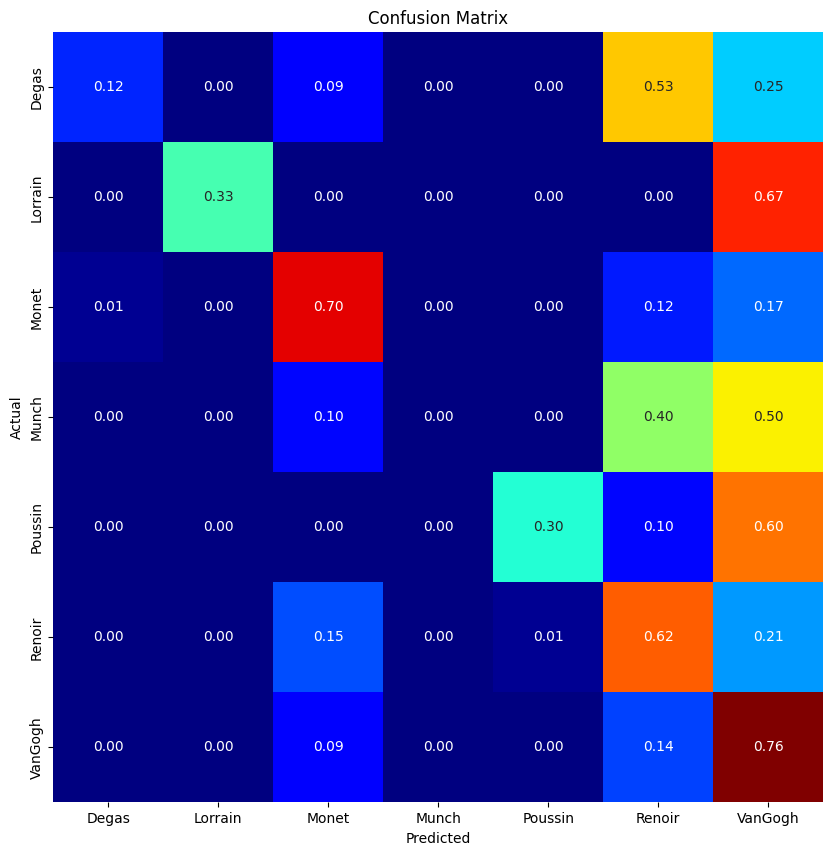

Classification Report:
              precision    recall  f1-score   support

       Degas       0.80      0.12      0.22        32
     Lorrain       1.00      0.33      0.50         6
       Monet       0.67      0.70      0.68        69
       Munch       0.00      0.00      0.00        10
     Poussin       0.75      0.30      0.43        10
      Renoir       0.50      0.62      0.55        71
     VanGogh       0.60      0.76      0.67        97

    accuracy                           0.59       295
   macro avg       0.62      0.41      0.44       295
weighted avg       0.61      0.59      0.56       295



In [27]:
import seaborn as sns

y_pred = best_model.predict(X_test.reshape(len(X_test), -1))
accuracy = classification_report(y_test, y_pred, target_names=labels)
conf_matrix = confusion_matrix(y_test, y_pred)

row_sums = conf_matrix.sum(axis=1, keepdims=True)
conf_matrix_percent = (conf_matrix / row_sums) 

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", square=True, cbar=False, cmap=plt.cm.jet, xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print('Classification Report:')
print(accuracy)

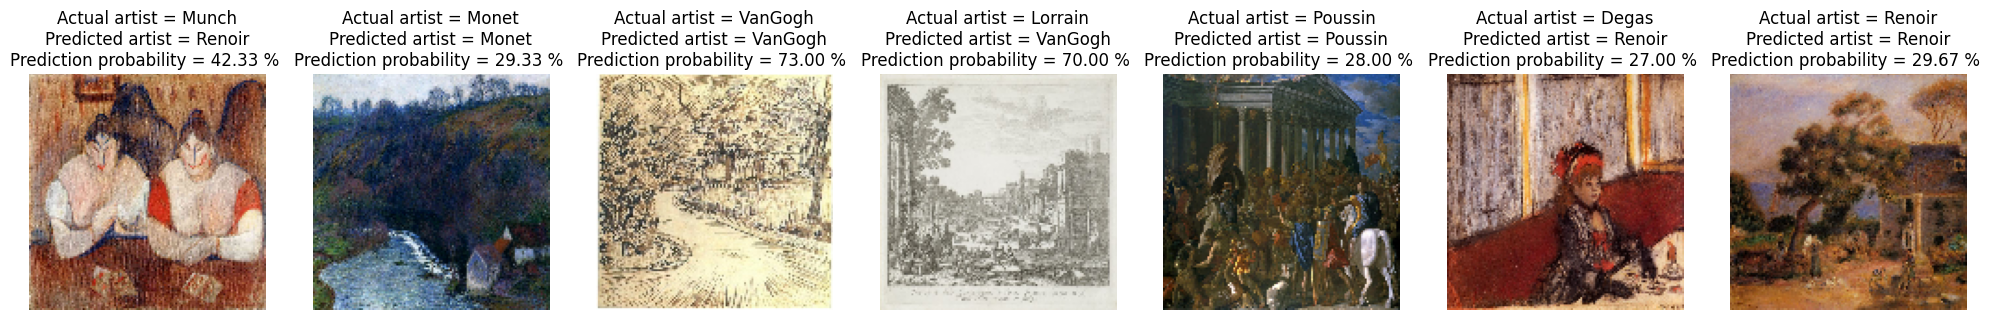

In [34]:
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np

n = 7
fig, axes = plt.subplots(1, n, figsize=(25, 10))

unique_artists = list(set(labels))

for i in range(n):
    random_artist = random.choice(unique_artists)
    unique_artists.remove(random_artist)

    random_image = random.choice(os.listdir(os.path.join(test_directory, random_artist)))
    random_image_file = os.path.join(test_directory, random_artist, random_image)

    test_image = plt.imread(random_image_file)

    test_image = cv.resize(test_image, (128, 128))
    test_image = np.array(test_image) / 255
    prediction = best_model.predict(test_image.reshape(1, -1))
    prediction_artist = labels[prediction[0]]

    prediction_probabilities = best_model.predict_proba(test_image.reshape(1, -1))[0]
    max_probability = max(prediction_probabilities)  
    prediction_idx = prediction_probabilities.argmax() 

    title = "Actual artist = {}\nPredicted artist = {}\n".format(random_artist.replace('_', ' '), prediction_artist.replace('_', ' '))
    title += "Prediction probability = {:.2f} % ".format(max_probability * 100)

    axes[i].imshow(test_image)
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()
